<a href="https://colab.research.google.com/github/amazzoli/ComponentSystemsData/blob/main/tutorials/1_Load_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cloning the repository in the colab folder structure
%%bash
git clone https://github.com/amazzoli/ComponentSystemsData.git

Cloning into 'ComponentSystemsData'...


In [69]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys

sys.path.append('/content/ComponentSystemsData/py_utils/')
import plot_utils as pu

In [44]:
from scipy.sparse import coo_matrix, lil_matrix

class ComponentSystem(object):

  """
  Class storing all the properties of a component system and computing the
  main statistical properties
  """

  def __init__(self, objects, components, count_sparse):
    """
    Args:
    - objects: pandas table with the list of objects.
    - components: pandas table with the list of components.
    - sparse_counts: pandas table with the sparse counts.
    """

    self.objects = objects
    self.components = components

    # Constructing the sparse lil_matrix. It is probably more efficient to pass
    # from the coo_matrix given the way we store the values in count_sparse
    row_col_indexes = count_sparse['object_id'], count_sparse['component_id']
    self.mat = coo_matrix((count_sparse['count'].values, row_col_indexes))
    self.mat = self.mat.tolil().transpose()


  def check_consistency(self):
    """
    Check if the identifiers and the summation of rows and columns in the objects
    and realization tables are consistent with the sparse count matrix.
    """
    pass


repo_folder = '/content/ComponentSystemsData/'
metadata = pd.read_csv(repo_folder + 'metadata.tsv', sep='\t', index_col=0)


def load_system(label):
  """
  Return a ComponentSystem object for the given label. Labels are listed in the
  metadata.tsv file.
  """

  if label not in metadata.index:
    raise ValueError('Label {} not found in metadata.tsv'.format(label))

  data_folder = 'datasets/{}/data/'.format(label)
  objects = pd.read_csv(repo_folder + data_folder + 'objects.tsv', sep='\t', index_col=0)
  components = pd.read_csv(repo_folder + data_folder + 'components.tsv', sep='\t', index_col=0)
  count_sparse = pd.read_csv(repo_folder + data_folder + 'count_sparse.zip', sep='\t', compression='zip')

  return ComponentSystem(objects, components, count_sparse)

In [45]:
cs = load_system('legos')

In [46]:
cs.mat

<List of Lists sparse matrix of dtype 'int64'
	with 1240234 stored elements and shape (91248, 33530)>

In [47]:
cs.objects

,set_id,name,year,n_themes,theme1,theme2,theme3,size,vocabulary
sparse_id,,,,,,,,,
12800,7349-1,Skater Boy,2004.0,3,Duplo,Town,Legoville,2,2
17890,Sp12-1,Wheel Bearings for Locomotives,1977.0,2,Service Packs,Train,NaN,2,1
20544,fig-002544,BB-8,NaN,1,Minifigure,NaN,NaN,2,2
26667,fig-008787,"Baby - Bright Light Blue Body, Bib",NaN,1,Minifigure,NaN,NaN,2,2
12842,7450-1,Stretchy,2003.0,2,Duplo,Little Robots,NaN,2,2
...,...,...,...,...,...,...,...,...,...
13058,75192-1,Millennium Falcon,2017.0,2,Star Wars,Ultimate Collector Series,NaN,7691,704
328,10276-1,Colosseum,2020.0,1,Icons,NaN,NaN,9125,220
344,10294-1,Titanic,2021.0,1,Icons,NaN,NaN,9185,692


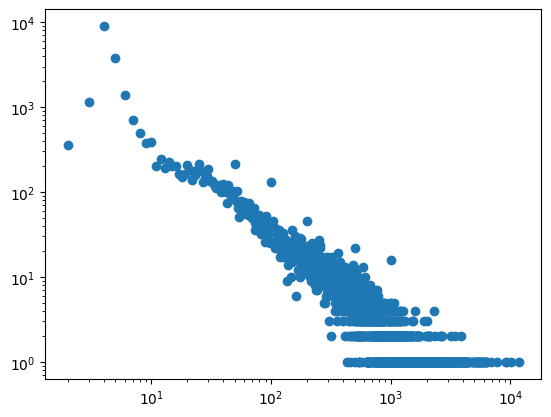

In [72]:
sizes = np.array(cs.mat.sum(axis=0))[0]

ax = plt.subplot()
ax = pu.plot_count_hist_nobin(ax, sizes)